In [9]:
import numpy as np
import pandas as pd
from mriqc_learn.datasets import load_dataset
from mriqc_learn.viz import metrics
from mriqc_learn.models.preprocess import SiteRobustScaler

# Load some example data

In [7]:
(train_x, train_y), (_, _) = load_dataset(split_strategy="none")
train_x["site"] = train_y.site
ratings = np.array(["Exclude"] * len(train_x))

ratings[train_y.rater_3.values == 0] = "Doubtful"
ratings[train_y.rater_3.values == 1] = "Accept"

In [8]:
(test_x, test_y), (_, _) = load_dataset("ds030", split_strategy="none")
test_x["site"] = test_y.site
ratings_test = np.array(["Exclude"] * len(test_x))

ratings_test[test_y.rater_1.values == 0] = "Doubtful"
ratings_test[test_y.rater_1.values == 1] = "Accept"

In [10]:
merged_x = pd.concat((train_x, test_x))

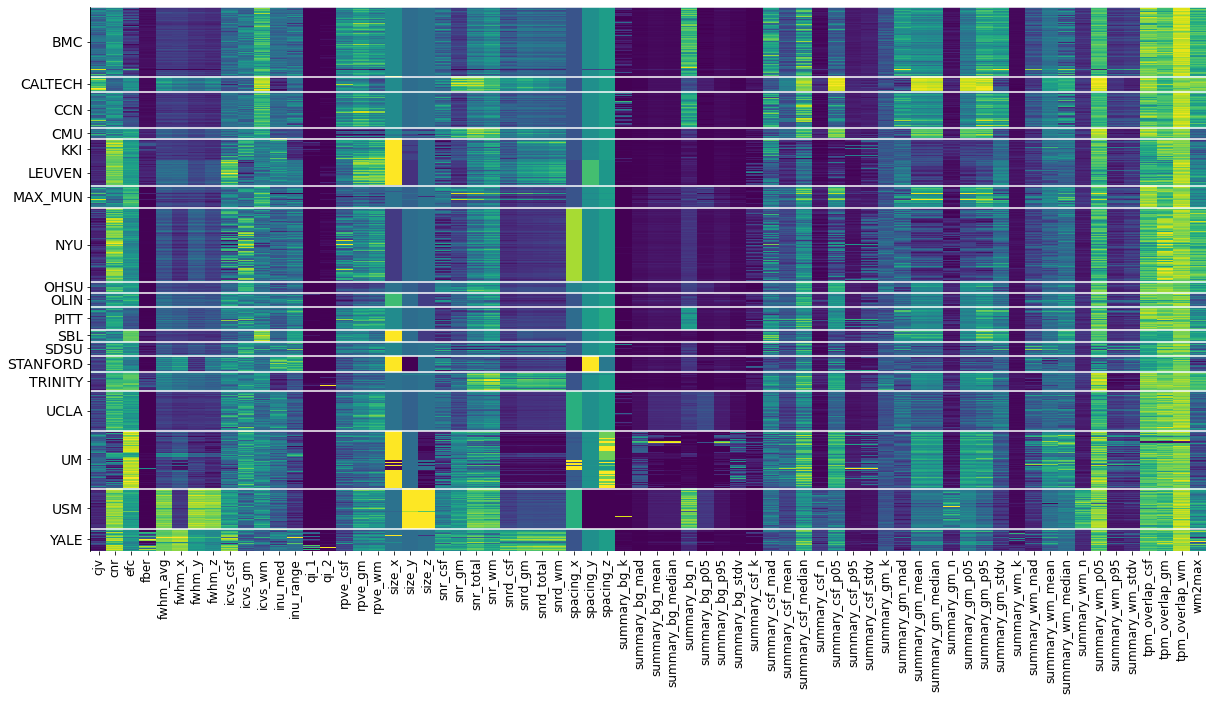

In [11]:
metrics.plot_batches(merged_x);

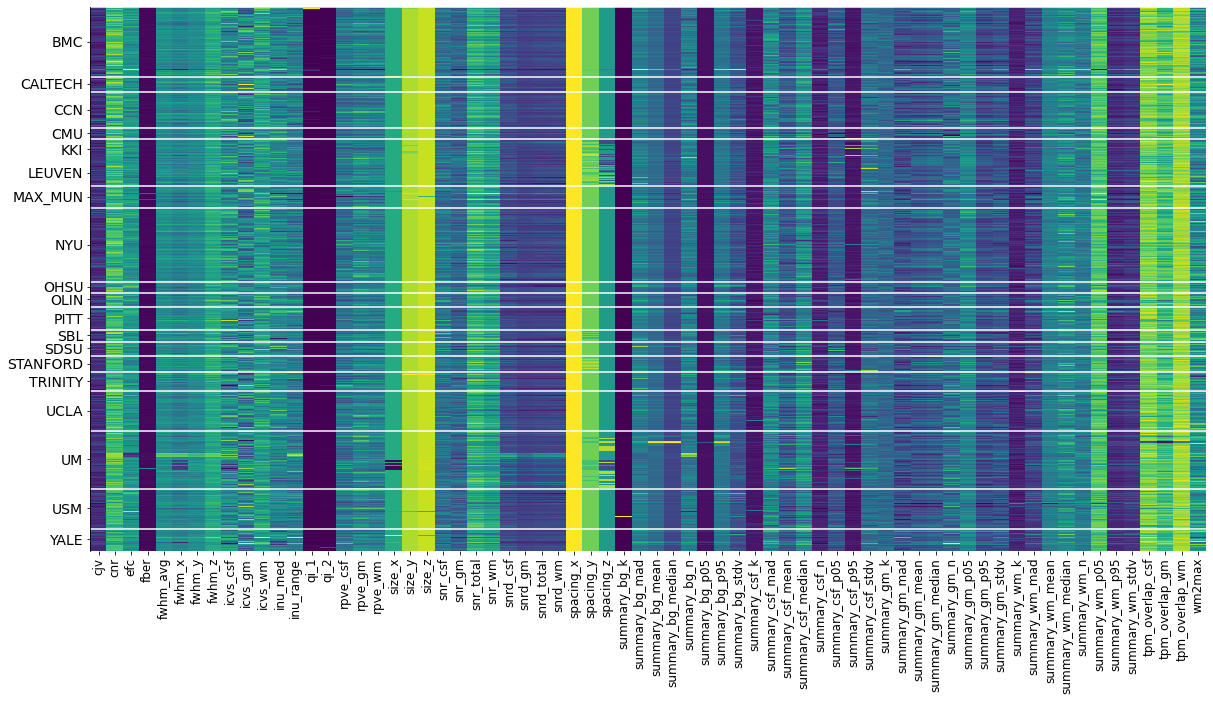

In [13]:
scaled_x = SiteRobustScaler(unit_variance=True).fit_transform(merged_x)
fig2 = metrics.plot_batches(scaled_x)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [17]:
groups = Counter(merged_x.site.values.squeeze().tolist()).most_common()

In [18]:
groups

[('NYU', 184),
 ('BMC', 174),
 ('UM', 145),
 ('USM', 101),
 ('UCLA', 99),
 ('CCN', 91),
 ('LEUVEN', 64),
 ('PITT', 57),
 ('MAX_MUN', 57),
 ('YALE', 56),
 ('KKI', 54),
 ('TRINITY', 49),
 ('STANFORD', 40),
 ('CALTECH', 38),
 ('OLIN', 36),
 ('SDSU', 36),
 ('SBL', 30),
 ('OHSU', 28),
 ('CMU', 27)]

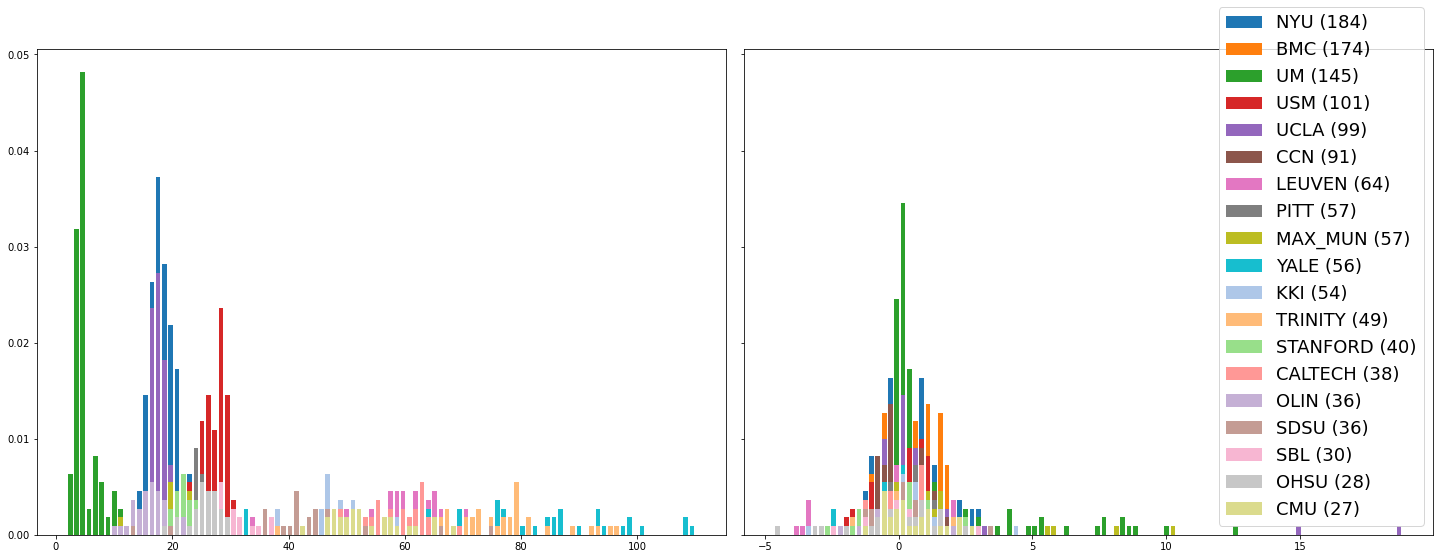

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True, constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.1, wspace=0)

colors = list(plt.cm.get_cmap('tab20').colors)
colors = colors[::2] + colors[1::2]
ax1.set_prop_cycle(color=colors)
ax2.set_prop_cycle(color=colors)

nstd_snrd_total = [train_x[train_x.site.str.contains(g)].snrd_total.values.squeeze().tolist() for g, _ in groups]
nstd_iqm_min, nstd_iqm_max = train_x.snrd_total.min(), train_x.snrd_total.max()
nstd_bin_sides = np.linspace(nstd_iqm_min, nstd_iqm_max, 101, endpoint=True)
nstd_bin_centers = nstd_bin_sides[1:] + 0.5 * (nstd_bin_sides[1] - nstd_bin_sides[0])

std_snrd_total = [scaled_x[scaled_x.site.str.contains(g)].snrd_total.values.squeeze().tolist() for g, _ in groups]
std_iqm_min, std_iqm_max = scaled_x.snrd_total.min(), scaled_x.snrd_total.max()
std_bin_sides = np.linspace(std_iqm_min, std_iqm_max, 101, endpoint=True)
std_bin_centers = std_bin_sides[1:] + 0.5 * (std_bin_sides[1] - std_bin_sides[0])


for site, n in groups:
    nstd_site_data = train_x[train_x.site.str.contains(site)]
    nstd_iqm = nstd_site_data.snrd_total.values.squeeze().tolist()
    nstd_hist, _ = np.histogram(
        nstd_iqm,
        bins=100,
        weights=[1/len(train_x)] * len(nstd_iqm),
        range=(nstd_iqm_min, nstd_iqm_max),
    )
    
    std_site_data = scaled_x[scaled_x.site.str.contains(site)]
    std_iqm = std_site_data.snrd_total.values.squeeze().tolist()
    std_hist, _ = np.histogram(
        std_iqm,
        bins=100,
        weights=[1/len(train_x)] * len(std_iqm),
        range=(std_iqm_min, std_iqm_max),
    )
    
    ax1.bar(nstd_bin_centers, height=nstd_hist, label=f"{site} ({n})")
    ax2.bar(std_bin_centers, height=std_hist, label=f"{site} ({n})", width=0.18)
    
    
ax2.legend(prop={'size': 18});